In [70]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [73]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [74]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [75]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER

# TODO try different date ranges
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2018-10-01'
TEST_START_DATE = '2018-10-01'
TEST_END_DATE = '2021-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (89201, 8)


In [76]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [77]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)


Successfully added technical indicators
Successfully added turbulence index


In [78]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [79]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

# buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# num_stock_shares = [0] * stock_dimension
# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }

In [80]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)
# e_train_gym = StockTradingEnv(df = processed, **env_kwargs)
# agent = DRLAgent(e_train_gym)
# if_using_a2c = True
# model_a2c = agent.get_model("a2c")
# # if if_using_a2c:
# #   tmp_path = RESULTS_DIR + '/a2c'
# #   new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# #   model_a2c.set_logger(new_logger_a2c)
# trained_a2c = agent.train_model(model=model_a2c,
#                              tb_log_name='a2c',
#                              total_timesteps=50000)

In [81]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

In [82]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  175.2200684053388
======Model training from:  2009-01-01 to  2018-10-02
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c\a2c_126_4
--------------------------------------
| time/                 |            |
|    fps                | 110        |
|    iterations         | 100        |
|    time_elapsed       | 4          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -1.05      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -35.5      |
|    reward             | 0.60151696 |
|    std                | 1.01       |
|    value_loss         | 0.956      |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps 

In [83]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2018-10-02,2019-01-03,TD3,-0.248568,-0.165757,-0.208614,-0.16166,-0.13949
1,189,2019-01-03,2019-04-04,TD3,0.374945,0.371406,0.359443,0.394671,0.398728
2,252,2019-04-04,2019-07-05,PPO,0.055525,0.178076,0.168427,0.168845,0.086845
3,315,2019-07-05,2019-10-03,DDPG,-0.219191,-0.223352,-0.1302,-0.24534,-0.191391
4,378,2019-10-03,2020-01-03,TD3,0.499821,0.43313,0.267675,0.399432,0.749905
5,441,2020-01-03,2020-04-03,SAC,-0.453048,-0.432418,-0.384987,-0.341691,-0.437438
6,504,2020-04-03,2020-07-06,PPO,0.236087,0.28152,0.224198,0.265614,0.266977
7,567,2020-07-06,2020-10-02,A2C,0.36712,0.071345,0.160887,0.253415,0.19213


In [84]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [85]:
import pandas as pd

# Assuming these variables are already defined
# unique_trade_date, rebalance_window, validation_window

# Create DataFrame for trade dates
df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

# Initialize an empty DataFrame for account values
df_account_value = pd.DataFrame()

# Read and concatenate CSV files
for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble', i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)

# Calculate Sharpe Ratio
sharpe = (252 ** 0.5) * df_account_value.account_value.pct_change(1).mean() / df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio:', sharpe)

# Join DataFrames
df_account_value = df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))


Sharpe Ratio: 0.9254812596144365


In [86]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2019-01-03,NaN,2019-01-03
1,1.006198e+06,2019-01-04,0.006198,2019-01-04
2,1.008966e+06,2019-01-07,0.002751,2019-01-07
3,1.017043e+06,2019-01-08,0.008004,2019-01-08
4,1.019192e+06,2019-01-09,0.002113,2019-01-09


<Axes: >

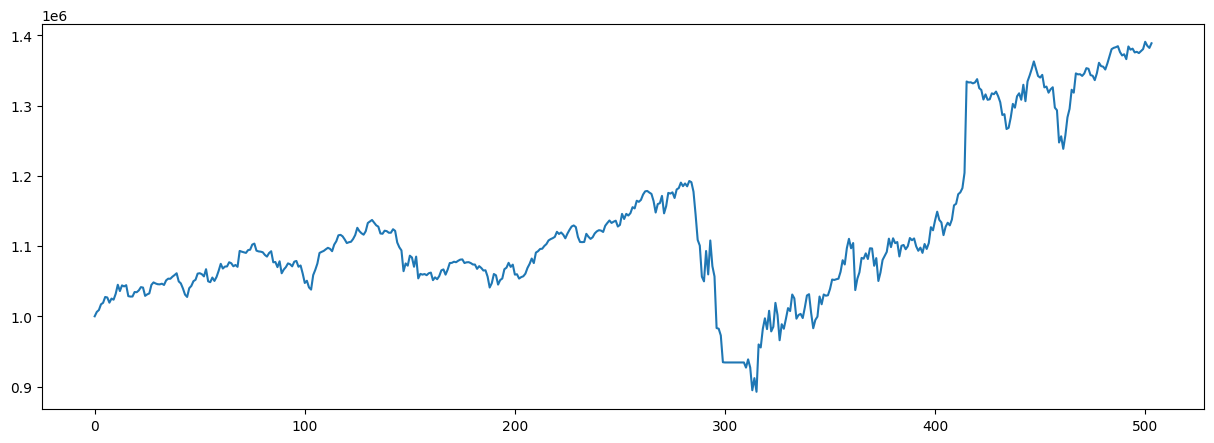

In [87]:
%matplotlib inline
df_account_value.account_value.plot()

In [88]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.178460
Cumulative returns     0.388767
Annual volatility      0.199074
Sharpe ratio           0.925481
Calmar ratio           0.709134
Stability              0.361652
Max drawdown          -0.251659
Omega ratio            1.212132
Sortino ratio          1.379314
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995668
Daily value at risk   -0.024350
dtype: float64


In [89]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (503, 8)
Annual return          0.158112
Cumulative returns     0.340442
Annual volatility      0.274367
Sharpe ratio           0.674393
Calmar ratio           0.426336
Stability              0.110621
Max drawdown          -0.370862
Omega ratio            1.160709
Sortino ratio          0.931304
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.863958
Daily value at risk   -0.033833
dtype: float64


In [90]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')

df_dji:             date           dji
0    2019-01-03  1.000000e+06
1    2019-01-04  1.032925e+06
2    2019-01-07  1.037253e+06
3    2019-01-08  1.048542e+06
4    2019-01-09  1.052583e+06
..          ...           ...
499  2020-12-24  1.331199e+06
500  2020-12-28  1.340195e+06
501  2020-12-29  1.337185e+06
502  2020-12-30  1.340442e+06
503  2020-12-31           NaN

[504 rows x 2 columns]
df_dji:                       dji
date                    
2019-01-03  1.000000e+06
2019-01-04  1.032925e+06
2019-01-07  1.037253e+06
2019-01-08  1.048542e+06
2019-01-09  1.052583e+06
...                  ...
2020-12-24  1.331199e+06
2020-12-28  1.340195e+06
2020-12-29  1.337185e+06
2020-12-30  1.340442e+06
2020-12-31           NaN

[504 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2018-10-02
1    2018-10-03
2    2018-10-04
3    2018-10-05
4    2018-10-08
..          ...
600  2021-02-22
601  2021-02-23
602  2021-02-24
603  2021-02-25
604  2021-02-26

[605 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2019-01-03  1.000000e+06
2019-01-04  1.006198e+06
2019-01-07  1.008966e+06
2019-01-08  1.017043e+06
2019-01-09  1.019192e+06
...                  ...
2020-12-24  1.380477e+06
2020-12-28  1.390897e+06
2020-12-29  1.385171e+06
2020-12-30  1.382172e+06
2020-12-31  1.388767e+06

[504 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2019-01-03  1.000000e+06  1.000000e+06
2019-01-04  1.006198e+06  1.032925e+06
2019-01-07  1.008966e+06  1.037253e+06
2019-01-08  1.017043e+06  1.048542e+06
2019-01-09  1.019192e+06  1.052583e+06
...       

<Figure size 1500x500 with 0 Axes>

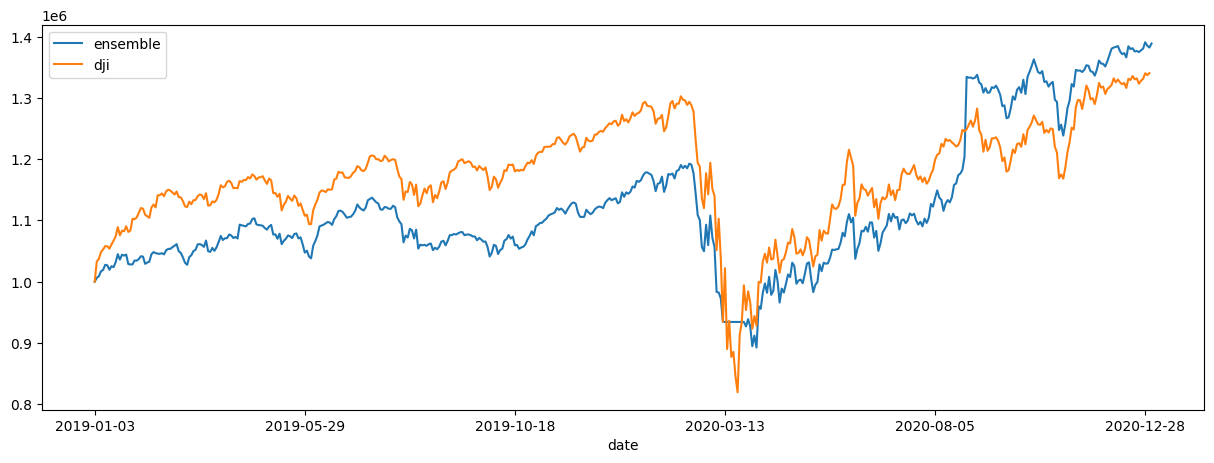

In [91]:
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

print(result)

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();